# Calibrate MGLU Pricer with `SciPy`

## 导入模型

In [1]:
import numpy as np
# import pandas as pd

import torch 

import sys
sys.path.append('../')
sys.path.append('../../')

# 导入模型
from Networks.nn import NN_pricing_MGLU
from Pricing.rBergomi.rBergomi_utils import *
from calibrate_utils import *

# 评估使用 cpu
device = torch.device('cpu')

# 设置参数为 4 个
hyperparams = { 
    'input_dim': 4, 
    'hidden_dim': 64, 
    'hidden_nums': 4,
    'output_dim': 88
}

model = NN_pricing_MGLU(hyperparams=hyperparams).to(device=device, dtype=torch.float64)


model_state = torch.load( 
    r'../../Results/models/MGLU_rBergomi_flat_forward_variance.pth'
)
model.load_state_dict(model_state)

# 设置为 eval mode
model.eval()
model.to(device=device, dtype=torch.float64)

NN_pricing_MGLU(
  (layer_lst): ModuleList(
    (0): MGLUBlock(
      (mglu_projection): MGLU(in_features=4, out_features=64, bias=False)
    )
    (1-3): 3 x MGLUBlock(
      (mglu_projection): MGLU(in_features=64, out_features=64, bias=False)
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (output_layer): Linear(in_features=64, out_features=88, bias=True)
)

In [5]:
def test_network_sensitivity(model, device, base_params):
    """测试网络输出对输入微小变化的敏感性"""
    model.eval()
    base_params = torch.tensor(base_params, dtype=torch.float64).to(device)
    # 基础输出
    with torch.no_grad():
        base_output = model(base_params.unsqueeze(0)).squeeze(0)
    
    sensitivities = []
    param_names = ['H', 'eta', 'rho', 'v0']
    for i in range(4):
        # 创建扰动参数
        delta = torch.zeros_like(base_params)
        delta[i] = 0.01  # 扰动1%
        pert_params = base_params + delta
        
        with torch.no_grad():
            pert_output = model(pert_params.unsqueeze(0)).squeeze(0)
        
        # 计算输出变化的L2范数
        diff_norm = torch.norm(pert_output - base_output, p=2).item()
        sensitivities.append((param_names[i], diff_norm))
        
        print(f"参数 {param_names[i]} 变化 1%, 输出变化 L2 范数: {diff_norm:.6f}")
        # 可选：打印最大变化位置
        max_diff, max_idx = torch.max(torch.abs(pert_output - base_output), 0)
        print(f"  最大变化: {max_diff.item():.6f}, 位于输出维度 {max_idx.item()}")
    
    return sensitivities

# 使用一个典型参数进行测试
base_params = [0.1, 2.0, -0.7, 0.04]
sens = test_network_sensitivity(model, device, base_params)

参数 H 变化 1%， 输出变化 L2 范数: 0.034344
  最大变化: 0.008659， 位于输出维度 5
参数 eta 变化 1%， 输出变化 L2 范数: 0.023068
  最大变化: 0.004944， 位于输出维度 44
参数 rho 变化 1%， 输出变化 L2 范数: 0.092682
  最大变化: 0.017494， 位于输出维度 18
参数 v0 变化 1%， 输出变化 L2 范数: 0.092378
  最大变化: 0.024949， 位于输出维度 10


## 数据

In [2]:
# 数据集
import gzip
f = gzip.GzipFile(
    filename = r"../../Data/rBergomiTrainSet.txt.gz", 
    mode = "r"
)

data = np.load(f)
xx, yy = data[:, :4], data[:, 4:]

strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

# xx: 参数
## 前 4 列代表网格所对应的参数
xx = data[:, :4]
print(f"参数形状：{xx.shape}")

# yy: 隐含波动率曲面 
# 后 88 列表示隐含波动率曲面 8 * 11 = 88
yy = data[:, 4:]
print(f"隐含波动率曲面形状：{yy.shape}")

# 参数
print(f"参数上界: {np.max(xx, axis=0)}")
print(f"参数下界: {np.min(xx, axis=0)}")


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('../')

# from NN_Training.rBergomi_nn_pricer import x_transform, x_inv_transform, y_transform, y_inv_transform, params_scaler, params_inv_scaler


x_train, x_test, y_train, y_test = train_test_split(xx, yy, test_size=0.15, random_state=42)

scale_x, scale_y = StandardScaler(), StandardScaler()


# 工具函数——数据标准化
def x_transform(train_data, test_data): 
    return scale_x.fit_transform(train_data), scale_x.transform(test_data)

def x_inv_transform(x):
    return scale_x.inverse_transform(x)

def y_transform(train_data, test_data): 
    return scale_y.fit_transform(train_data), scale_y.transform(test_data)

def y_inv_transform(y):
    return scale_y.inverse_transform(y)


# 训练集的 Upper and Lower Bounds
upper_bound = np.array([0.16,4,-0.1,0.5])
lower_bound = np.array([0.01,0.3,-0.95,0.025])

def params_scaler(x): 
    return (x - (upper_bound+lower_bound) / 2 ) * 2 / (upper_bound-lower_bound)

def params_inv_scaler(x):
    return x * (upper_bound-lower_bound) / 2 + (upper_bound+lower_bound) / 2


x_train_transform = params_scaler(x_train)
x_test_transform = params_scaler(x_test)

y_train_transform, y_test_transform = y_transform(y_train, y_test)


train_data = (torch.from_numpy(x_train_transform).to(device=device),torch.from_numpy(y_train_transform).to(device=device))

test_data = (torch.from_numpy(x_test_transform).to(device=device),torch.from_numpy(y_test_transform).to(device=device))


print(f"训练集形状：{train_data[0].shape}")
print(f"测试集形状：{test_data[0].shape}")

参数形状：(40000, 4)
隐含波动率曲面形状：(40000, 88)
参数上界: [ 0.16      4.       -0.100011  0.499998]
参数下界: [ 0.0100133  0.300028  -0.949934   0.0250066]
训练集形状：torch.Size([34000, 4])
测试集形状：torch.Size([6000, 4])


## `PyTorch` 校准

### 优化

In [8]:
import torch.nn as nn

loss_MSE = nn.MSELoss()

vol_model = y_inv_transform(model(test_data[0]).detach().numpy())
vol_real = y_test

error_real = np.abs(vol_model-vol_real)
error_relative = error_real/vol_real

np.mean(error_relative)


def calibrate_with_torch_lbfgs(model, y_test_transform, device='cpu'):
    """ 
    使用 LBFGS 优化器

    Args:
        model (torch.nn.Module): 模型
        y_test_transform (torch.Tensor): 隐含波动率曲面
        device (str, optional): 设备. Defaults to 'cpu'.
        
    Returns:
        Approx_lbfgs (numpy.ndarray): LBFGS 优化结果
    """

    model = model.to(device)
    model.eval()  # 评估模式
    
    Approx = []
    Timing = []
    
    # 转换为tensor
    y_test_tensor = torch.from_numpy(y_test_transform).float().to(device)
    
    for i in range(len(y_test_tensor)):
        print(f"{i+1}/{len(y_test_tensor)}", end="\r")
        
        # 初始化待优化参数（需要梯度）
        params = torch.tensor([ 
            torch.empty(1).uniform_(0.05, 0.15).item(),
            torch.empty(1).uniform_(1.5, 2.5).item(),
            torch.empty(1).uniform_(-0.9, -0.5).item(),
            torch.empty(1).uniform_(0.02, 0.06).item()
        ], dtype=torch.float64, requires_grad=True, device=device)
        
        # 获取当前样本的真实值
        target = y_test_tensor[i].unsqueeze(0)  # 形状: (1, ...)
        
        # 定义 LBFGS 优化器
        optimizer = torch.optim.LBFGS(
            [params],
            lr=1.0,
            max_iter=10000,
            tolerance_grad=1e-10,
            tolerance_change=1e-10,
            history_size=100,
            line_search_fn='strong_wolfe'
        )
        
        # 定义 closure 函数
        def closure():
            optimizer.zero_grad()
            
            # 神经网络预测（参数需要先转换格式）
            params_reshaped = params.unsqueeze(0)  # 形状: (1, 4)
            predicted = model(params_reshaped)
            
            # 计算损失（MSE）
            loss = torch.sum((predicted - target) ** 2)
            
            # 反向传播
            loss.backward()
            
            return loss
        
        # 优化
        start = time.time()
        
        # LBFGS优化循环
        max_epochs = 100
        for epoch in range(max_epochs):
            loss = optimizer.step(closure)
            
            # 提前停止条件
            if loss.item() < 1e-10:
                break
        
        end = time.time()
        
        # 记录结果
        solutions = params.detach().cpu().numpy()
        times = end - start
        
        Approx.append(solutions)
        Timing.append(times)
    
    return np.array(Approx), np.array(Timing)




Approx_torch, Timing_torch = calibrate_with_torch_lbfgs(model, y_test_transform[:100], device='cpu')
Approx_torch = params_inv_scaler(Approx_torch)


print(f"LBFGS 优化结果 (前 10 个):\n {Approx_torch[:10]}")
print(f"LBFGS 优化时间 (前 10 个):\n {Timing_torch[:10]}")

KeyboardInterrupt: 

In [6]:
torch.zeros(4)

tensor([0., 0., 0., 0.])

## `SciPy` 校准

### 优化

In [3]:
def CostFunc(x,sample_ind):
    return np.sum( 
        np.power((model(torch.from_numpy(x)).detach().numpy() - y_test_transform[sample_ind]),2)
    )

Approx_scipy, Timing_scipy = calibrate_with_scipy(CostFunc, x_test_transform, upper_bound, lower_bound)

SciPy 优化结果 (前 3 轮):
 [[[ 0.085   2.15   -0.525   0.2625]
  [ 0.085   2.15   -0.525   0.2625]
  [ 0.085   2.15   -0.525   0.2625]]

 [[ 0.085   2.15   -0.525   0.2625]
  [ 0.085   2.15   -0.525   0.2625]
  [ 0.085   2.15   -0.525   0.2625]]

 [[ 0.085   2.15   -0.525   0.2625]
  [ 0.085   2.15   -0.525   0.2625]
  [ 0.085   2.15   -0.525   0.2625]]]
SciPy 优化时间 (前 3 轮):
 [array([0.01301575, 0.0059998 , 0.00700355]), array([0.00599957, 0.00651455, 0.00500011]), array([0.00599957, 0.006001  , 0.01143813])]


In [ ]:
methods=["L-BFGS-B ","SLSQP","BFGS"]

for i in range(3):
    Approx_scipy_lst=[Approx_scipy[j][i] for j in range(len(Approx_scipy))]
    Timing_scipy_lst=[Timing_scipy[j][i] for j in range(len(Timing_scipy))]

    np.savetxt(f"../../Results/Calibration/rBergomi_MGLU_calibrate_scipy_quasi_newton_{methods[i]}.txt", Approx_scipy_lst)
    np.savetxt(f"../../Results/Calibration/rBergomi_MGLU_calibrate_scipy_quasi_newton_{methods[i]}_time.txt", Timing_scipy_lst)

### 可视化

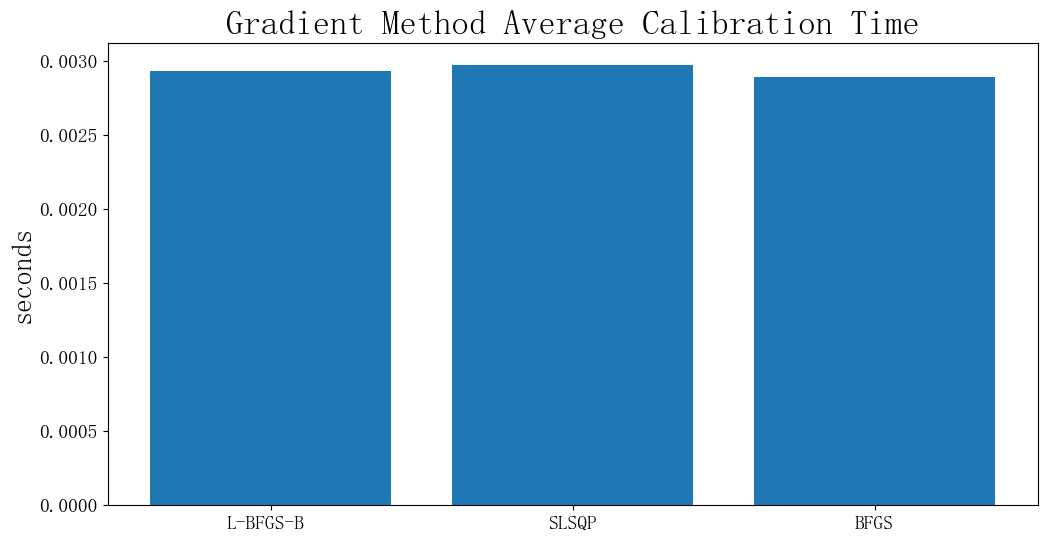

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

methods=["L-BFGS-B ","SLSQP","BFGS"]
plt.figure(1,figsize=(12,6))
plt.bar(methods,np.mean(Timing_scipy,axis=0))
plt.title("Gradient Method Average Calibration Time",fontsize=25)
plt.ylabel("seconds",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

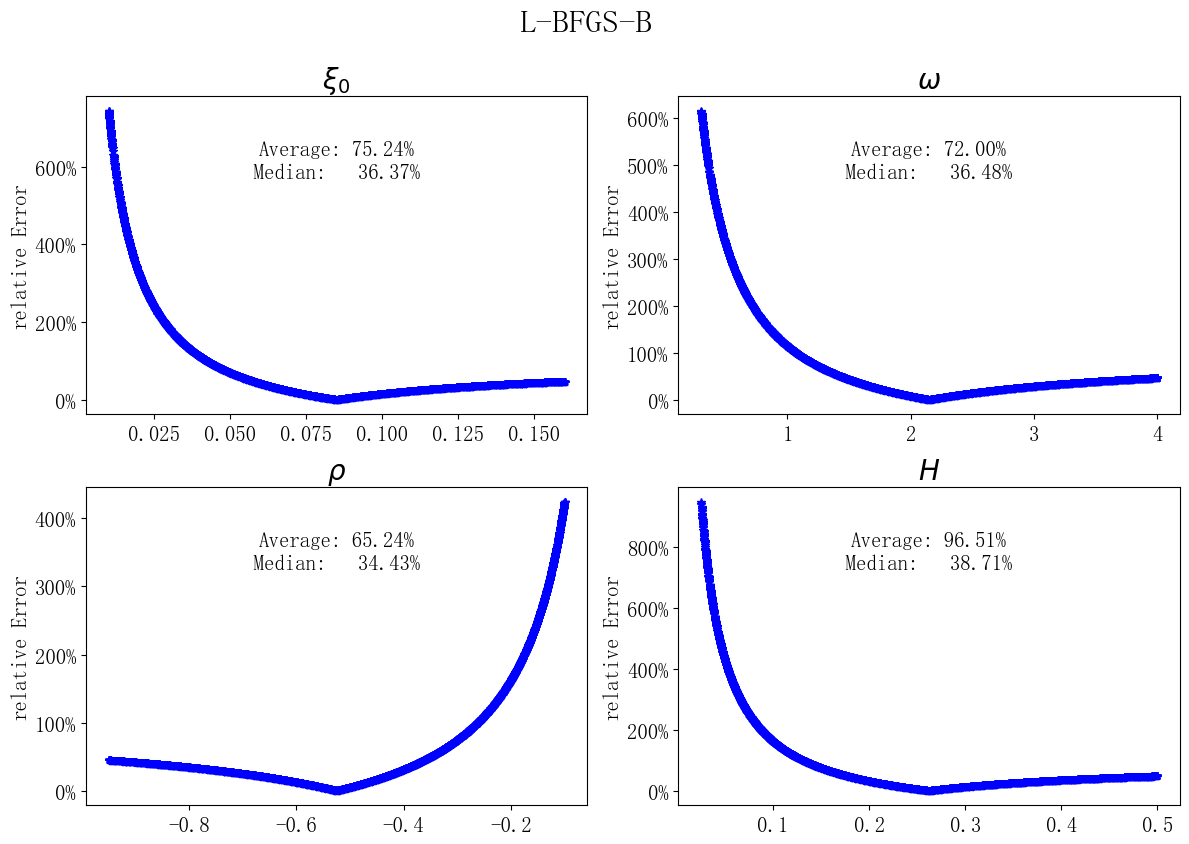

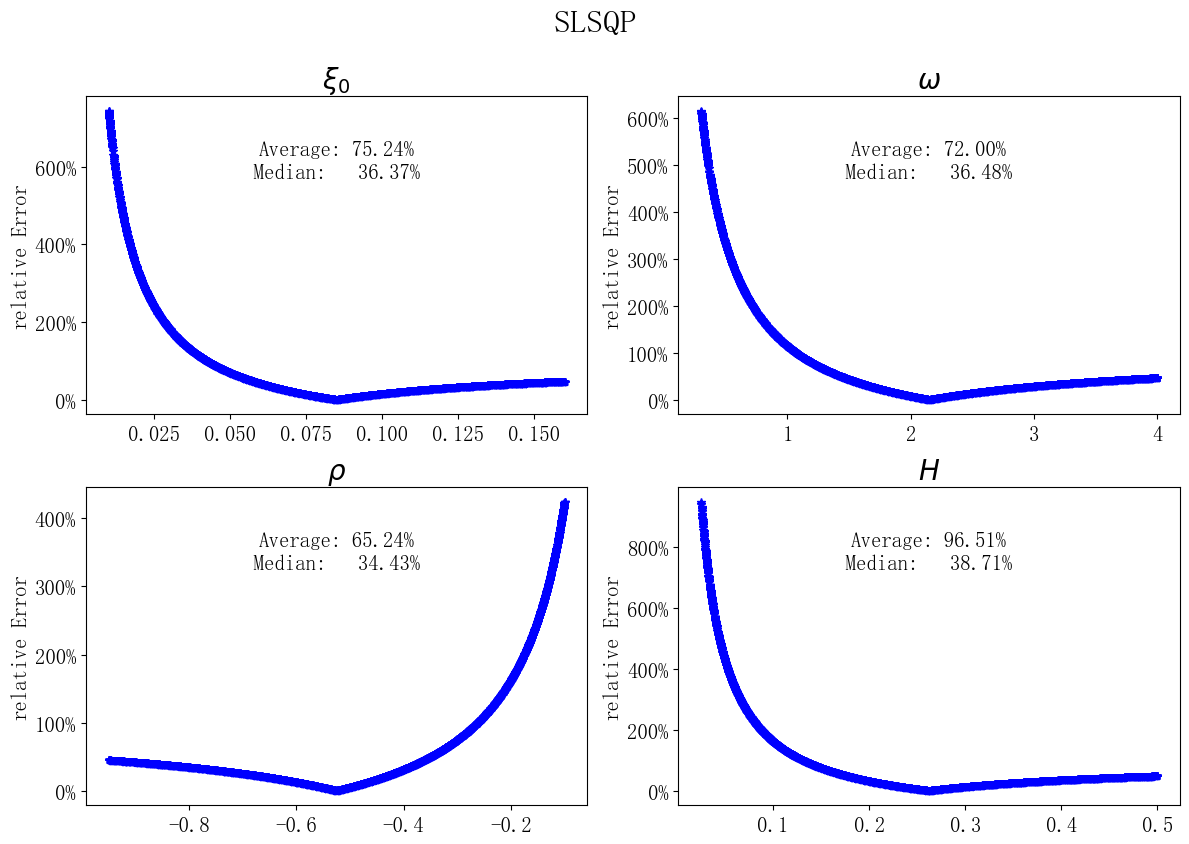

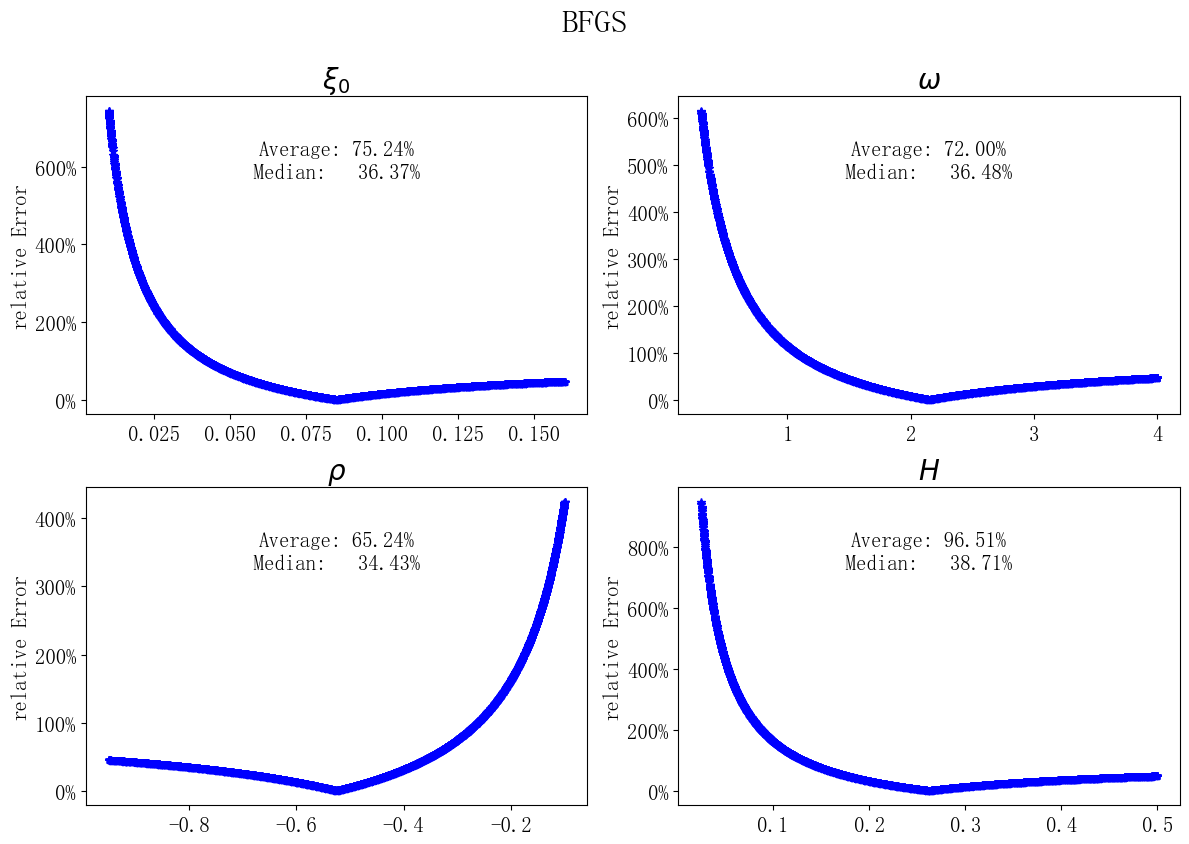

In [6]:
x_test = params_inv_scaler(x_test_transform, upper_bound, lower_bound)

for mtd in range(3):
    LMParameters = [Approx_scipy[i][mtd] for i in range(len(Approx_scipy))]
    LMParameters = np.array(LMParameters)

    titles=["$\\xi_0$","$\\omega$","$\\rho$","$H$"]
    average=np.zeros([4,6000])
    fig=plt.figure(figsize=(12,8))
    for u in range(4):
        ax=plt.subplot(2,2,u+1)
        x=x_test[:6000,u]
        plt.plot(x,100*np.abs(LMParameters[:6000,u]-x)/np.abs(x),'b*')
        average[u,:]=np.abs(LMParameters[:6000,u]-x)/np.abs(x)
        
        plt.title(titles[u],fontsize=20)
        plt.ylabel('relative Error',fontsize=15)
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
        plt.tick_params(axis='both', which='major', labelsize=15)
        plt.tick_params(axis='both', which='minor', labelsize=15)
        plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median:   %1.2f%% '%(np.mean(100*average[u,:]),np.quantile(100*average[u,:],0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)
    plt.tight_layout()
    plt.suptitle(f"{methods[mtd]}", fontsize=24, y=1.05)
    plt.show()